## Setup Models

In [1]:
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
import os

# --- Added to pickup the GitHub token
# From Course Hands-On AI: Introduction to Retrieval-Augmented Generation (RAG) - Yujian Tang
# Repo-file: https://github.com/GabrielECoy/introduction-to-retrieval-augmented-generation-rag-with-hands-on-projects-2023442/blob/main/chapter_1/08_challenge.ipynb
import dotenv
dotenv.load_dotenv()
if not os.getenv("GITHUB_TOKEN"):
    raise ValueError("GITHUB_TOKEN is not set")
#os.environ["OPENAI_API_KEY"] = os.getenv("GITHUB_TOKEN")
#os.environ["OPENAI_BASE_URL"] = "https://models.inference.ai.azure.com/"
# --- Added to pickup the GitHub token

#Setup the environment variables
os.environ["AZURE_OPENAI_API_KEY"]= os.getenv("GITHUB_TOKEN") # "4e4ab31800a64ae892cbb768fe28c0fc"
os.environ["AZURE_OPENAI_ENDPOINT"]="https://models.inference.ai.azure.com/" # "https://agentic-ai-course-kumaran.openai.azure.com/"

#Setup the LLM
model = AzureChatOpenAI(
    azure_deployment="gpt-4o" ,
    api_version="2023-03-15-preview",
    model="gpt-4o"
)


## 05.02. Engineer prompts for reflection

In [2]:
summarizer_prompt="""
You are an document summarizer who can summarize a document provide to you.
For the input provided, create a summary with less than 50 words.
If the user has provides critique, responsed with a revised version of your previous attempts
"""

reviewer_prompt="""
You are a reviewer grading summaries for an article. 
Compare the user input document and generated summary.
Check if the summary accurately reflects the contents of the document.
Provide recommendations for improvement in less than 50 words.
"""


## 05.03. Setup the summary-with-review Agent

In [3]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

class SummaryAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class SummaryAgent:
    
    def __init__(self, model, summarizer_prompt, reviewer_prompt, debug=False):
        
        self.model=model
        self.summarizer_prompt=summarizer_prompt
        self.reviewer_prompt=reviewer_prompt
        self.debug=debug
    
        summary_agent_graph=StateGraph(SummaryAgentState)
        summary_agent_graph.add_node("summarizer",self.generate_summary)
        summary_agent_graph.add_node("reviewer",self.review_summary)

        summary_agent_graph.add_conditional_edges(
            "summarizer",
            self.should_continue,
            {True: "reviewer", False: END }
        )
        summary_agent_graph.add_edge("reviewer", "summarizer")
        summary_agent_graph.set_entry_point("summarizer")

        #Add chat memory
        self.memory=MemorySaver()
        #Compile the graph
        self.summary_agent_graph = summary_agent_graph.compile(checkpointer=self.memory)

    def generate_summary(self, state:SummaryAgentState):
        messages=state["messages"]

        #Prepend summarizer system prompt to messages
        messages = [SystemMessage(content=self.summarizer_prompt)] + messages
        
        #invoke the summarizer with the message history
        result = self.model.invoke(messages)
        
        if self.debug:
            print(f"==============\n Generator returned output : {result.content}")
        return { "messages":[result] }

    def review_summary(self, state:SummaryAgentState):
        messages=state["messages"]

        #Prepend Reviewer system prompt to messages
        messages = [SystemMessage(content=self.reviewer_prompt)] + messages
        
        #invoke the reviewer with the message history
        result = self.model.invoke(messages)
        
        if self.debug:
            print(f"*************\n Reviewer returned output : {result.content}")
        return { "messages":[result] }

    def should_continue(self, state:SummaryAgentState):

        total_reviews = len(state["messages"]) / 2
        
        if self.debug:
            print(f"Iteration number : { total_reviews }")

        #Return if 2 iterations are completed. Each iteration has 2 messages
        if len(state["messages"]) > 4:
            return False
        else:
            return True
    

## 05.04. Setup the summary-with-review Chatbot

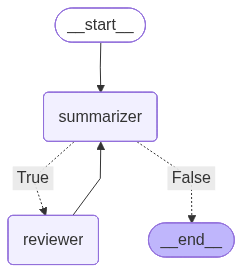

In [11]:
from IPython.display import Image
from langchain_community.document_loaders import PyPDFLoader

#Setup the summary chatbot
summary_chatbot = SummaryAgent(model, 
                               summarizer_prompt, 
                               reviewer_prompt,
                               debug=True)

#Visualize the Agent
Image(summary_chatbot.summary_agent_graph.get_graph().draw_mermaid_png())

#Visualize the Agent in ascii format
#try:
#    import grandalf.graphs
#except ImportError:
#    %pip install grandalf==0.8
#print(summary_chatbot.summary_agent_graph.get_graph().draw_ascii())
#           +-----------+            
#           | __start__ |            
#           +-----------+            
#                 *                  
#                 *                  
#                 *                  
#          +------------+            
#          | summarizer |            
#          +------------+            
#           ..         ...           
#         ..              .          
#        .                 ..        
#+----------+           +---------+  
#| reviewer |           | __end__ |  
#+----------+           +---------+  


In [12]:
#Input file for execution
# Load, chunk and index the contents of the pdf.
loader=PyPDFLoader("./data/EcoSprint_Specification_Document.pdf")
docs = loader.load()

#Pick the first page of the doc as content
source_content=docs[0].page_content.replace("\n"," ")
print(f"Input :==============\n {source_content}\n")

Input :==============
 EcoSprint SpecificationDocument 1.Overview● TheEcoSprint isarevolutionaryelectricvehicle(EV)designedforefficiencyandperformance. Withitssleekdesignandstate-of-the-art technology, theEcoSprintappealstoenvironmentallyconsciousdriverswhodon't want tocompromiseonstyleordrivingexperience. Ideal forcitydrivinganddailycommutes, theEcoSprint offersaperfect blendof comfort, sustainability, andinnovation. 2.DesignSpecifications● ExteriorDesign: TheEcoSprint boastsamodernandaerodynamicsilhouette, featuringsmoothlinesandacompact formfactor. AvailableincolorslikeMidnight Black, OceanBlue, andPearl White, it'sahead-turnerontheroad.● InteriorDesign: Inside, theEcoSprint isarealmof comfort andluxury. It offersaspaciouscabinwithseatingforfive, premiumupholstery, andcustomizableambientlighting. 3.PerformanceSpecifications● EngineandMotor: Poweredbyahigh-efficiencyelectricmotor, theEcoSprint delivers200horsepowerand300Nmof torque, providingasmoothandresponsivedrivingexperience.● Ba

## 05.05. Execute the summary-with-review chatbot

In [13]:
import uuid
#Execute a single request with debug ON
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

messages=[HumanMessage(content=source_content)]
result=summary_chatbot.summary_agent_graph.invoke({"messages":messages},config)
print(f"Final output :==============\n {result['messages'][-1].content}\n")

 Generator returned output : The EcoSprint is an innovative electric vehicle designed for efficiency, performance, and sustainability. It features sleek aesthetics, a 250-mile range, advanced driver assistance, luxury interiors, and cutting-edge technology like smartphone integration and remote monitoring, offering a perfect blend of style, comfort, and eco-conscious driving.
Iteration number : 1.0
*************
 Reviewer returned output : The summary is accurate but lacks detail on performance specifications (acceleration, top speed) and safety/security features. Including these aspects would provide a more comprehensive overview of the EcoSprint's offerings while maintaining conciseness.
 Generator returned output : The EcoSprint is a cutting-edge electric vehicle blending efficiency, style, and performance. It offers a sleek design, luxury interiors, 250-mile range, 0-60 mph in 7.3 seconds, advanced safety/security features, and smart technology like smartphone integration and remot

In [ ]:
#Take user feedback on the summary through a chatbot
summary_chatbot = SummaryAgent(model, 
                               summarizer_prompt, 
                               reviewer_prompt,
                               debug=True)


user_inputs = [
    source_content,
    "Can you rewrite the review by focusing more on the specifications?",
    "Can you remove details about the touchscreen?"
]

#Create a new thread
config = {"configurable": {"thread_id": "thread-summarizer"}}

#Given the number of iterations, this will take a long time.
for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = summary_chatbot.summary_agent_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")

    # Because the agent is stateful, the next input will be processed with the previous messages in the thread.
    # The agent will continue to generate summaries and reviews until the number of iterations exceeds the limit set in the should_continue function.
    # That means the calls to the agent for the additional user inputs will not use the reviewer node because the number of messages in the thread will exceed the limit set in the should_continue function.

----------------------------------------
USER : EcoSprint SpecificationDocument 1.Overview● TheEcoSprint isarevolutionaryelectricvehicle(EV)designedforefficiencyandperformance. Withitssleekdesignandstate-of-the-art technology, theEcoSprintappealstoenvironmentallyconsciousdriverswhodon't want tocompromiseonstyleordrivingexperience. Ideal forcitydrivinganddailycommutes, theEcoSprint offersaperfect blendof comfort, sustainability, andinnovation. 2.DesignSpecifications● ExteriorDesign: TheEcoSprint boastsamodernandaerodynamicsilhouette, featuringsmoothlinesandacompact formfactor. AvailableincolorslikeMidnight Black, OceanBlue, andPearl White, it'sahead-turnerontheroad.● InteriorDesign: Inside, theEcoSprint isarealmof comfort andluxury. It offersaspaciouscabinwithseatingforfive, premiumupholstery, andcustomizableambientlighting. 3.PerformanceSpecifications● EngineandMotor: Poweredbyahigh-efficiencyelectricmotor, theEcoSprint delivers200horsepowerand300Nmof torque, providingasmoothandrespons